In [1]:
!pip -q install xgboost seaborn matplotlib


In [2]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv("Loan_Default.csv")
print("✅ Dataset loaded — shape:", df.shape)
df.head()


Saving Loan_Default.csv to Loan_Default.csv
✅ Dataset loaded — shape: (148670, 34)


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

TARGET = "Status"


df[TARGET] = df[TARGET].astype(str).str.lower().replace({
    'fully paid':0, 'paid':0, 'no':0,
    'charged off':1, 'default':1, 'yes':1
})

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)


for col in X.select_dtypes('object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Ensure all columns are numeric, coercing any non-numeric to NaN
# This helps SimpleImputer in the next step to reliably identify all missing values
X = X.apply(pd.to_numeric, errors='coerce')

# Impute missing values after label encoding and before scaling
# Using mean imputation for numerical columns
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

print("✅ Data ready! Train:", X_train.shape, " Test:", X_test.shape)

✅ Data ready! Train: (118936, 33)  Test: (29734, 33)


✅ Logistic Regression Accuracy: 68.30%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.69      0.77     22406
           1       0.41      0.65      0.50      7328

    accuracy                           0.68     29734
   macro avg       0.63      0.67      0.64     29734
weighted avg       0.75      0.68      0.70     29734



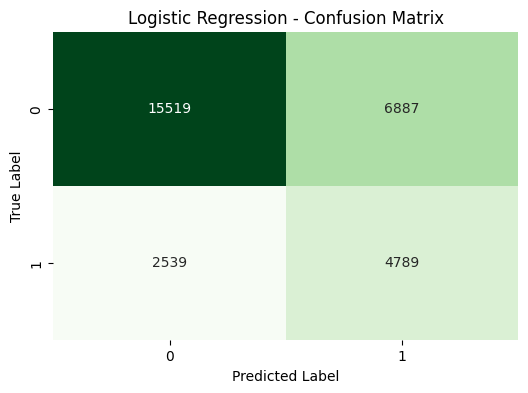

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Define model
log_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

#Train
log_model.fit(X_train_scaled, y_train)

#Predict
y_pred = log_model.predict(X_test_scaled)

#Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Logistic Regression Accuracy: {accuracy*100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

#Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


✅ Decision Tree Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



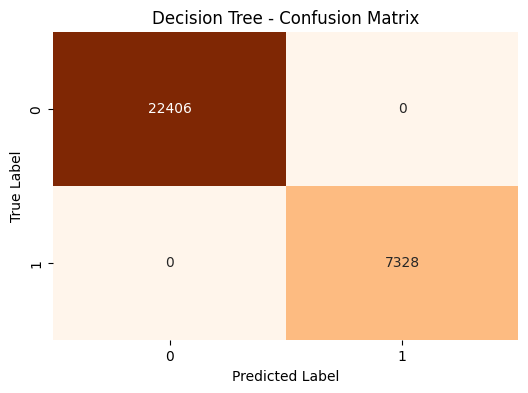

/tmp/ipython-input-1207725994.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='autumn')


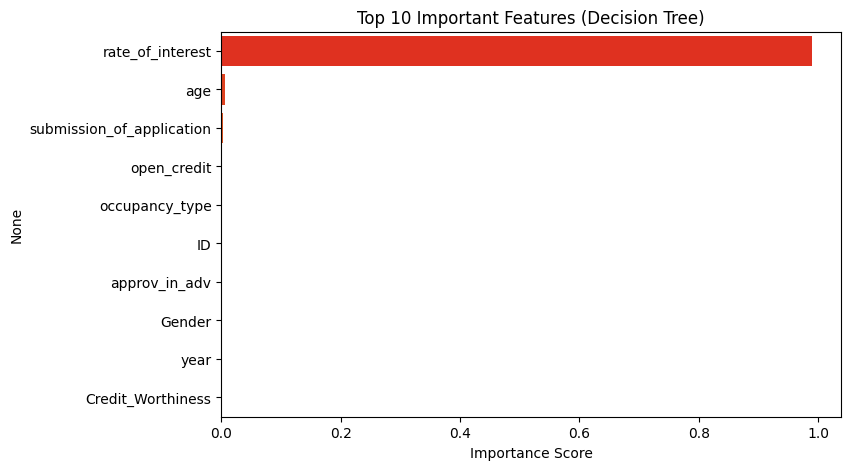

In [11]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(max_depth=None, class_weight='balanced', random_state=42)
tree_model.fit(X_train_scaled, y_train)

y_pred = tree_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Decision Tree Accuracy: {accuracy*100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title('Decision Tree - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

importances = pd.Series(tree_model.feature_importances_, index=X_train_scaled.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top_features.values, y=top_features.index, palette='autumn')
plt.title('Top 10 Important Features (Decision Tree)')
plt.xlabel('Importance Score')
plt.show()


✅ Random Forest Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



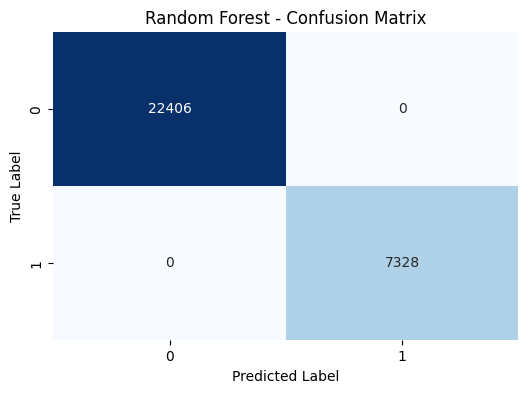

/tmp/ipython-input-1156500132.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


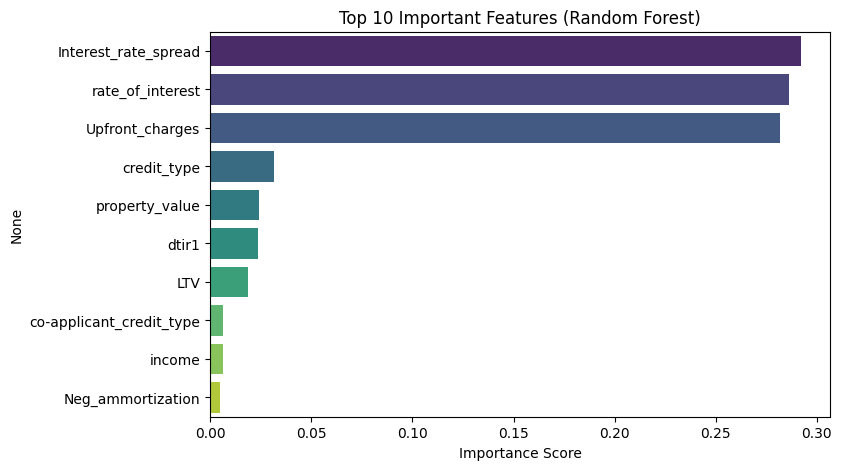

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)

rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Random Forest Accuracy: {accuracy*100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


importances = pd.Series(rf_model.feature_importances_, index=X_train_scaled.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top 10 Important Features (Random Forest)')
plt.xlabel('Importance Score')
plt.show()


In [13]:
# Sanity checks
print("✅ Target Balance:")
print(y_train.value_counts(normalize=True).round(2))
print("\n✅ Check for duplicates in test set:", X_test_scaled.duplicated().sum())


✅ Target Balance:
Status
0    0.75
1    0.25
Name: proportion, dtype: float64

✅ Check for duplicates in test set: 0


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_model.fit(X_train_scaled, y_train)
y_pred = log_model.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"✅ Logistic Regression Accuracy: {acc*100:.2f}%")
print(classification_report(y_test, y_pred))


✅ Logistic Regression Accuracy: 68.30%
              precision    recall  f1-score   support

           0       0.86      0.69      0.77     22406
           1       0.41      0.65      0.50      7328

    accuracy                           0.68     29734
   macro avg       0.63      0.67      0.64     29734
weighted avg       0.75      0.68      0.70     29734

